<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Contoh_transfer_learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Instalasi dan Import Library

In [2]:
# Jika belum, install dulu library yang dibutuhkan
#!pip install tensorflow matplotlib

# Import library
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

# Cell 2: Download dan Ekstrak Dataset

In [3]:
# Di sini digunakan dataset publik 'Flower Photos' dari TensorFlow
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)



228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [4]:
import os

print("Data dir:", data_dir)
print("Daftar isi folder utama:")
print(os.listdir(data_dir))

# Cek jumlah dan nama kelas (subfolder):
for name in os.listdir(data_dir):
    sub_path = os.path.join(data_dir, name)
    if os.path.isdir(sub_path):
        print(" -", name)

Data dir: /root/.keras/datasets/flower_photos
Daftar isi folder utama:
['flower_photos']
 - flower_photos


In [5]:
import pathlib

# Data_dir awal menunjuk ke dalam flower_photos satu kali lagi
data_dir = pathlib.Path("/root/.keras/datasets/flower_photos/flower_photos")
print("Isi:", list(data_dir.iterdir()))


Isi: [PosixPath('/root/.keras/datasets/flower_photos/flower_photos/sunflowers'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/daisy'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/tulips'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/LICENSE.txt'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/dandelion'), PosixPath('/root/.keras/datasets/flower_photos/flower_photos/roses')]


# Cell 3: Persiapan Dataset

In [8]:
# Split data menjadi training dan validation
batch_size = 32
img_height = 160
img_width = 160

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Simpan class names dan num_classes
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Jumlah kelas:", num_classes)

# Normalisasi untuk mempercepat konvergensi
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Jumlah kelas: 5


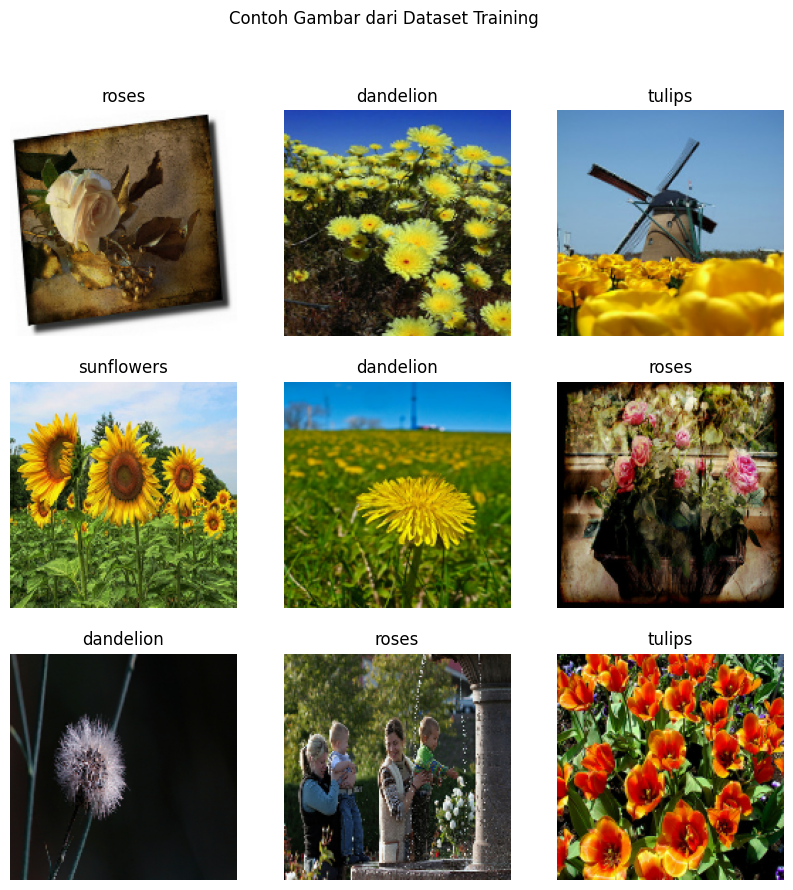

In [9]:
import matplotlib.pyplot as plt

# Ambil satu batch dari train_ds
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):  # Tampilkan 9 gambar pertama
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Contoh Gambar dari Dataset Training")
plt.show()

# Cell 4: Definisikan Model CNN Biasa

In [10]:
# Model CNN sederhana dengan Input layer
model_cnn = models.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # GUNAKAN num_classes dari cell 3
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Cell 5: Training dan Evaluasi Model CNN

In [11]:
history_cnn = model_cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.3350 - loss: 2.1272 - val_accuracy: 0.5681 - val_loss: 1.1036
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6068 - loss: 1.0191 - val_accuracy: 0.5804 - val_loss: 1.0212
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7102 - loss: 0.7499 - val_accuracy: 0.6076 - val_loss: 0.9721
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8426 - loss: 0.4545 - val_accuracy: 0.6022 - val_loss: 1.1465
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9407 - loss: 0.2109 - val_accuracy: 0.6008 - val_loss: 1.4318
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9625 - loss: 0.1153 - val_accuracy: 0.6158 - val_loss: 1.6522
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9844 - loss: 0.0545 - val_accuracy: 0.6117 - val_loss: 1.6298
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9875 - loss: 0.0390 - val_accuracy: 0.6063 -

# Cell 6: Arsitektur Transfer Learning (MobileNetV2)

In [12]:
# Load pre-trained MobileNetV2, exclude top classifier
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze pretrained layers

model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # num_classes dari cell 3
])


model_tl.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Cell 7: Training dan Evaluasi Model Transfer Learning

In [13]:
history_tl = model_tl.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 334ms/step - accuracy: 0.7182 - loss: 0.8203 - val_accuracy: 0.8665 - val_loss: 0.3690
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9138 - loss: 0.2365 - val_accuracy: 0.8692 - val_loss: 0.3386
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9576 - loss: 0.1315 - val_accuracy: 0.8978 - val_loss: 0.3295
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9830 - loss: 0.0794 - val_accuracy: 0.8801 - val_loss: 0.3585
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9936 - loss: 0.0417 - val_accuracy: 0.8937 - val_loss: 0.3677
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9970 - loss: 0.0250 - val_accuracy: 0.8747 - val_loss: 0.3792
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.8869 - val_loss: 0.3704
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.8951 

# Cell 8: Visualisasi Loss dan Akurasi

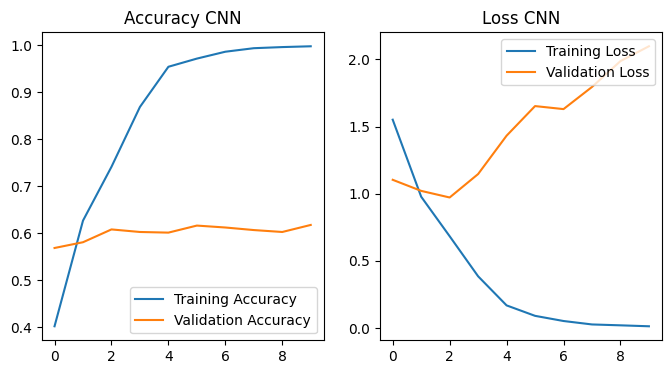

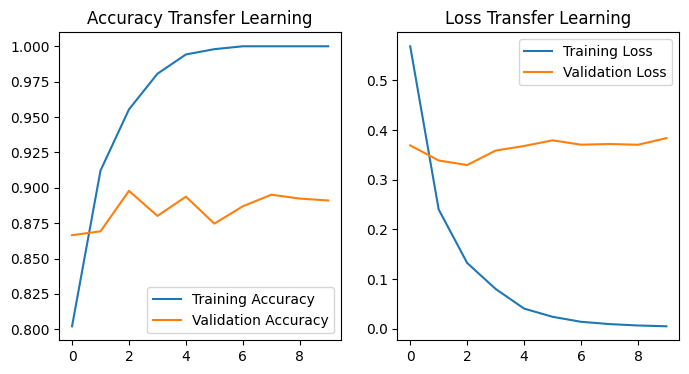

In [14]:
def plot_metrics(history, title_suffix=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy ' + title_suffix)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss ' + title_suffix)
    plt.show()

plot_metrics(history_cnn, title_suffix='CNN')
plot_metrics(history_tl, title_suffix='Transfer Learning')

# Cell 9: Evaluasi Model dan Saran Perbaikan

In [15]:
# Evaluasi di data validasi
val_loss_cnn, val_acc_cnn = model_cnn.evaluate(val_ds)
val_loss_tl, val_acc_tl = model_tl.evaluate(val_ds)

print(f"Model CNN - Validation accuracy: {val_acc_cnn:.2f}, loss: {val_loss_cnn:.2f}")
print(f"Transfer Learning - Validation accuracy: {val_acc_tl:.2f}, loss: {val_loss_tl:.2f}")

# Saran perbaikan:
print("""
Saran perbaikan kinerja model:
- Lanjutkan training transfer learning dengan unfreeze beberapa layer (fine-tuning)
- Coba augmentasi data (rotasi, flip, zoom, dsb.)
- Eksplorasi learning rate dan batch size
- Tambahkan regularisasi seperti dropout
- Gunakan model arsitektur lain yang lebih kompleks untuk dataset yang menantang
""")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6011 - loss: 2.1583
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8882 - loss: 0.3869
Model CNN - Validation accuracy: 0.62, loss: 2.10
Transfer Learning - Validation accuracy: 0.89, loss: 0.38

Saran perbaikan kinerja model:
- Lanjutkan training transfer learning dengan unfreeze beberapa layer (fine-tuning)
- Coba augmentasi data (rotasi, flip, zoom, dsb.)
- Eksplorasi learning rate dan batch size
- Tambahkan regularisasi seperti dropout
- Gunakan model arsitektur lain yang lebih kompleks untuk dataset yang menantang

